In [89]:
# comparison of cell viability CTG and cell count from HCA images

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


cpdata_raw = pd.read_csv("E:/OneDrive - National University of Ireland, Galway/CellPainting project data/Harmony/Nv6-PerWell/blastsProfiles.csv").drop(['Unnamed: 0'],axis=1, errors='ignore')
# cpdata = pd.read_csv("E:/OneDrive - National University of Ireland, Galway/CellPainting project data/Harmony/Nv6-PerWell/tubesProfilesNormalized.csv")

cpdata = cpdata_raw.copy()
cpdata.rename(columns={"Metadata_Object_Count":"Cell number"},inplace=True)
cpdata.sort_values(['Compound','Concentration'], inplace=True)

cpdata['Count'] = cpdata['Count']/5                         # average count per field instead of well, no field missing
cpdata['Replicate'] = cpdata['PlateName'].str[-1]  
controls = cpdata.loc[cpdata['Compound']=='DMSO']
controls.set_index(['PlateName','Compound'],inplace=True)
controlsMedian = controls.groupby(by=['Compound','Concentration','PlateName']).median(numeric_only=True).reset_index(drop=False)

#normalization of cpdata counts to DMSO median
for plate in cpdata.PlateName.unique():
    cpdata.loc[cpdata['PlateName']==plate,'Count'] = 100 * cpdata.loc[cpdata['PlateName']==plate,'Count'] / controlsMedian.loc[controlsMedian['PlateName']==plate,'Count'].values[0]
cpdata['Count'] = cpdata['Count'].round(decimals=3)
cpdata['DataType'] = 'Cell count'


In [90]:
# duplicate DMSO rows in each plate and replace compound name of DMSO to drug names to plot them as Vehicle 0nM

cp_data_with_dmso_as_drug = cpdata.copy()
for PlateName in cpdata.PlateName.unique():
    temp_df = cpdata.loc[cpdata['PlateName']==PlateName]
    for compound in temp_df.Compound.unique():
        if compound != 'DMSO':
            new_dmso = temp_df.loc[temp_df['Compound']=='DMSO']
            new_dmso.loc[:,'Compound'] = compound
            new_dmso = new_dmso.groupby(by=['PlateName','Compound','Replicate','DataType']).mean().reset_index(drop=False) #1 value per plate
            cp_data_with_dmso_as_drug = pd.concat([cp_data_with_dmso_as_drug,new_dmso],ignore_index=True)
cp_data_with_dmso_as_drug.drop(cp_data_with_dmso_as_drug.loc[cp_data_with_dmso_as_drug['Compound']=='DMSO'].index,inplace=True)
cp_data_with_dmso_as_drug.sort_values(['Compound','Concentration', 'PlateName'],inplace=True)
cp_data_with_dmso_as_drug

,Row,Column,Compound,Concentration,PlateName,Count,Cell 33342 Radial Mean,Cell 33342 Radial Mean Ratio SER-Bright,Cell 33342 Radial Mean Ratio SER-Dark,Cell 33342 Radial Mean Ratio SER-Edge,...,Ring Region Alexa 647 SER Bright 0 px,Ring Region Alexa 647 SER Dark 0 px,Ring Region Alexa 647 SER Edge 0 px,Ring Region Alexa 647 SER Hole 0 px,Ring Region Alexa 647 SER Ridge 0 px,Ring Region Alexa 647 SER Saddle 0 px,Ring Region Alexa 647 SER Spot 0 px,Ring Region Alexa 647 SER Valley 0 px,Replicate,DataType
3351,8.5,4.5,ATOR,0.0,blasts1-BR1,100.137167,1.387779e-17,1.619075e-17,-9.251859e-18,-9.251859e-18,...,2.602085e-17,-2.544261e-17,1.850372e-17,2.081668e-17,-5.782412e-18,-6.938894e-18,5.204170e-18,4.770490e-17,1,Cell count
3357,8.5,5.0,ATOR,0.0,blasts1-BR2,99.455833,5.859510e-17,3.729655e-17,3.083953e-17,3.083953e-18,...,3.700743e-17,0.000000e+00,-4.317534e-17,-4.625929e-17,-1.233581e-17,-3.083953e-18,1.850372e-17,2.467162e-17,2,Cell count
3363,8.5,5.0,ATOR,0.0,blasts1-BR3,99.693222,3.083953e-18,-3.083953e-17,5.898060e-17,-4.625929e-18,...,-1.541976e-18,-3.392348e-17,0.000000e+00,2.775558e-17,-6.476301e-17,-3.392348e-17,2.621360e-17,-1.233581e-17,3,Cell count
0,5.0,7.0,ATOR,10.0,blasts1-BR1,99.377000,-3.251434e-02,1.306296e+00,-3.380653e-01,-1.035786e-01,...,6.338537e-01,7.212686e-01,1.929303e-01,8.202400e-01,4.594600e-01,3.373297e-01,7.744283e-01,5.659478e-01,1,Cell count
1,5.0,8.0,ATOR,10.0,blasts1-BR1,99.153000,1.072954e+00,5.865001e-01,-7.053276e-01,-1.424406e+00,...,-5.804093e-01,-1.862042e-01,-1.043572e+00,2.902717e-01,-9.474711e-01,-9.704715e-01,-1.602415e-01,-4.477806e-01,1,Cell count
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,14.0,22.0,ZIDO,30000.0,blasts5-BR2,74.408000,1.004702e+01,1.560787e+01,3.502361e+00,1.949845e+00,...,-5.139555e-01,-1.242646e+00,-1.944219e+00,-6.984224e-01,-7.893596e-01,-2.116116e+00,-1.044928e-01,-1.653367e+00,2,Cell count
3347,13.0,21.0,ZIDO,30000.0,blasts5-BR3,81.723000,3.789126e+00,1.076545e+01,9.646797e+00,7.794509e+00,...,4.525447e+00,3.129161e+00,2.861356e+00,3.075914e+00,4.238849e+00,3.201879e+00,4.697935e+00,2.993713e+00,3,Cell count
3348,13.0,22.0,ZIDO,30000.0,blasts5-BR3,80.506000,5.339219e+00,7.535088e+00,3.072761e+00,3.687331e+00,...,3.211667e+00,2.693115e+00,1.053475e+00,3.025601e+00,2.625376e+00,1.437443e+00,3.366405e+00,2.078128e+00,3,Cell count
3349,14.0,21.0,ZIDO,30000.0,blasts5-BR3,77.712000,6.813112e+00,1.280086e+01,8.016187e+00,6.672329e+00,...,3.913531e+00,2.991942e+00,2.386158e+00,2.828094e+00,3.932400e+00,2.846697e+00,3.795784e+00,2.964168e+00,3,Cell count


In [112]:
CTGdata = pd.read_csv(r"E:\OneDrive - National University of Ireland, Galway\plate reader\normCTGresults.csv")
CTGdata = CTGdata[CTGdata['Plate'].str.contains("B")] # select cell type with B or T
CTGdata.sort_values(['Compound','Concentration'], inplace=True)
CTGdata['Replicate'] = CTGdata['Plate'].str[0]  # replicate letter


In [113]:
CTGdata['DataType'] = 'Cell viability'

CTGdata_with_dmso_as_drug = CTGdata.copy()
for PlateName in CTGdata.Plate.unique():
    temp_df = CTGdata.loc[CTGdata['Plate']==PlateName]
    for compound in temp_df.Compound.unique():
        if compound != 'DMSO':
            new_dmso = temp_df.loc[temp_df['Compound']=='DMSO']
            new_dmso.loc[:,'Compound'] = compound
            new_dmso = new_dmso.groupby(by=['Plate','Compound','Replicate','DataType']).mean().reset_index(drop=False) #1 value per plate
            CTGdata_with_dmso_as_drug = pd.concat([CTGdata_with_dmso_as_drug,new_dmso],ignore_index=True)
CTGdata_with_dmso_as_drug.drop(CTGdata_with_dmso_as_drug.loc[CTGdata_with_dmso_as_drug['Compound']=='DMSO'].index,inplace=True)
CTGdata_with_dmso_as_drug.sort_values(['Compound','Concentration', 'Plate'],inplace=True)
CTGdata_with_dmso_as_drug

,Compound,Concentration,Plate,Repeat,Cell Viability,Replicate,DataType
687,ATOR,0.0,aB1,1.0,100.000000,a,Cell viability
693,ATOR,0.0,bB1,1.0,100.000000,b,Cell viability
699,ATOR,0.0,gB1,1.0,100.000000,g,Cell viability
0,ATOR,10.0,aB1,1.0,98.131926,a,Cell viability
1,ATOR,10.0,bB1,1.0,100.184183,b,Cell viability
...,...,...,...,...,...,...,...
682,ZIDO,10000.0,bB5,1.0,99.942803,b,Cell viability
683,ZIDO,10000.0,gB5,1.0,100.021707,g,Cell viability
684,ZIDO,30000.0,aB5,1.0,82.919861,a,Cell viability
685,ZIDO,30000.0,bB5,1.0,100.551685,b,Cell viability


In [114]:
# perform significance test between each treatment-concentration and plate DMSO controls
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
t_tests_cpa = []
for compound in cp_data_with_dmso_as_drug.Compound.unique():
    compound_df = cp_data_with_dmso_as_drug.loc[cp_data_with_dmso_as_drug['Compound']==compound]
    for concentration in compound_df.Concentration.unique():
        if concentration > 0:
            treatment = compound_df.loc[compound_df['Concentration']==concentration]
            controls = compound_df.loc[compound_df['Concentration']==0].groupby(by=['PlateName']).mean(numeric_only=True)
            test = ttest_ind(treatment['Count'],controls['Count'])
            anova = f_oneway(treatment['Count'],controls['Count'])
            t_tests_cpa.append((compound,concentration,test[0],test[1], anova[0],anova[1]))

test_summary = pd.DataFrame(t_tests_cpa, columns=['Compound','Concentration','t-stat','p-value', 'F-stat','p-value anova'])
# count number of unique compounds with p-value < 0.05
test_summary.loc[test_summary['p-value']<0.05]

,Compound,Concentration,t-stat,p-value,F-stat,p-value anova
1,ATOR,30.0,-2.263202,4.138558e-02,5.122082,4.138558e-02
4,ATOR,1000.0,-2.548358,2.426785e-02,6.494130,2.426785e-02
5,ATOR,3000.0,-3.875028,1.914555e-03,15.015840,1.914555e-03
6,ATOR,10000.0,-5.400630,1.210112e-04,29.166807,1.210112e-04
7,ATOR,30000.0,-6.492519,2.027100e-05,42.152797,2.027100e-05
...,...,...,...,...,...,...
235,ZIDO,300.0,-7.595139,3.929978e-06,57.686130,3.929978e-06
236,ZIDO,1000.0,-11.570154,3.232754e-08,133.868464,3.232754e-08
237,ZIDO,3000.0,-9.213011,4.617020e-07,84.879575,4.617020e-07
238,ZIDO,10000.0,-11.085213,5.376800e-08,122.881958,5.376800e-08


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\roman\AppData\Local\Temp\ipykernel_43272\2013636859.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 3200x2400 with 0 Axes>

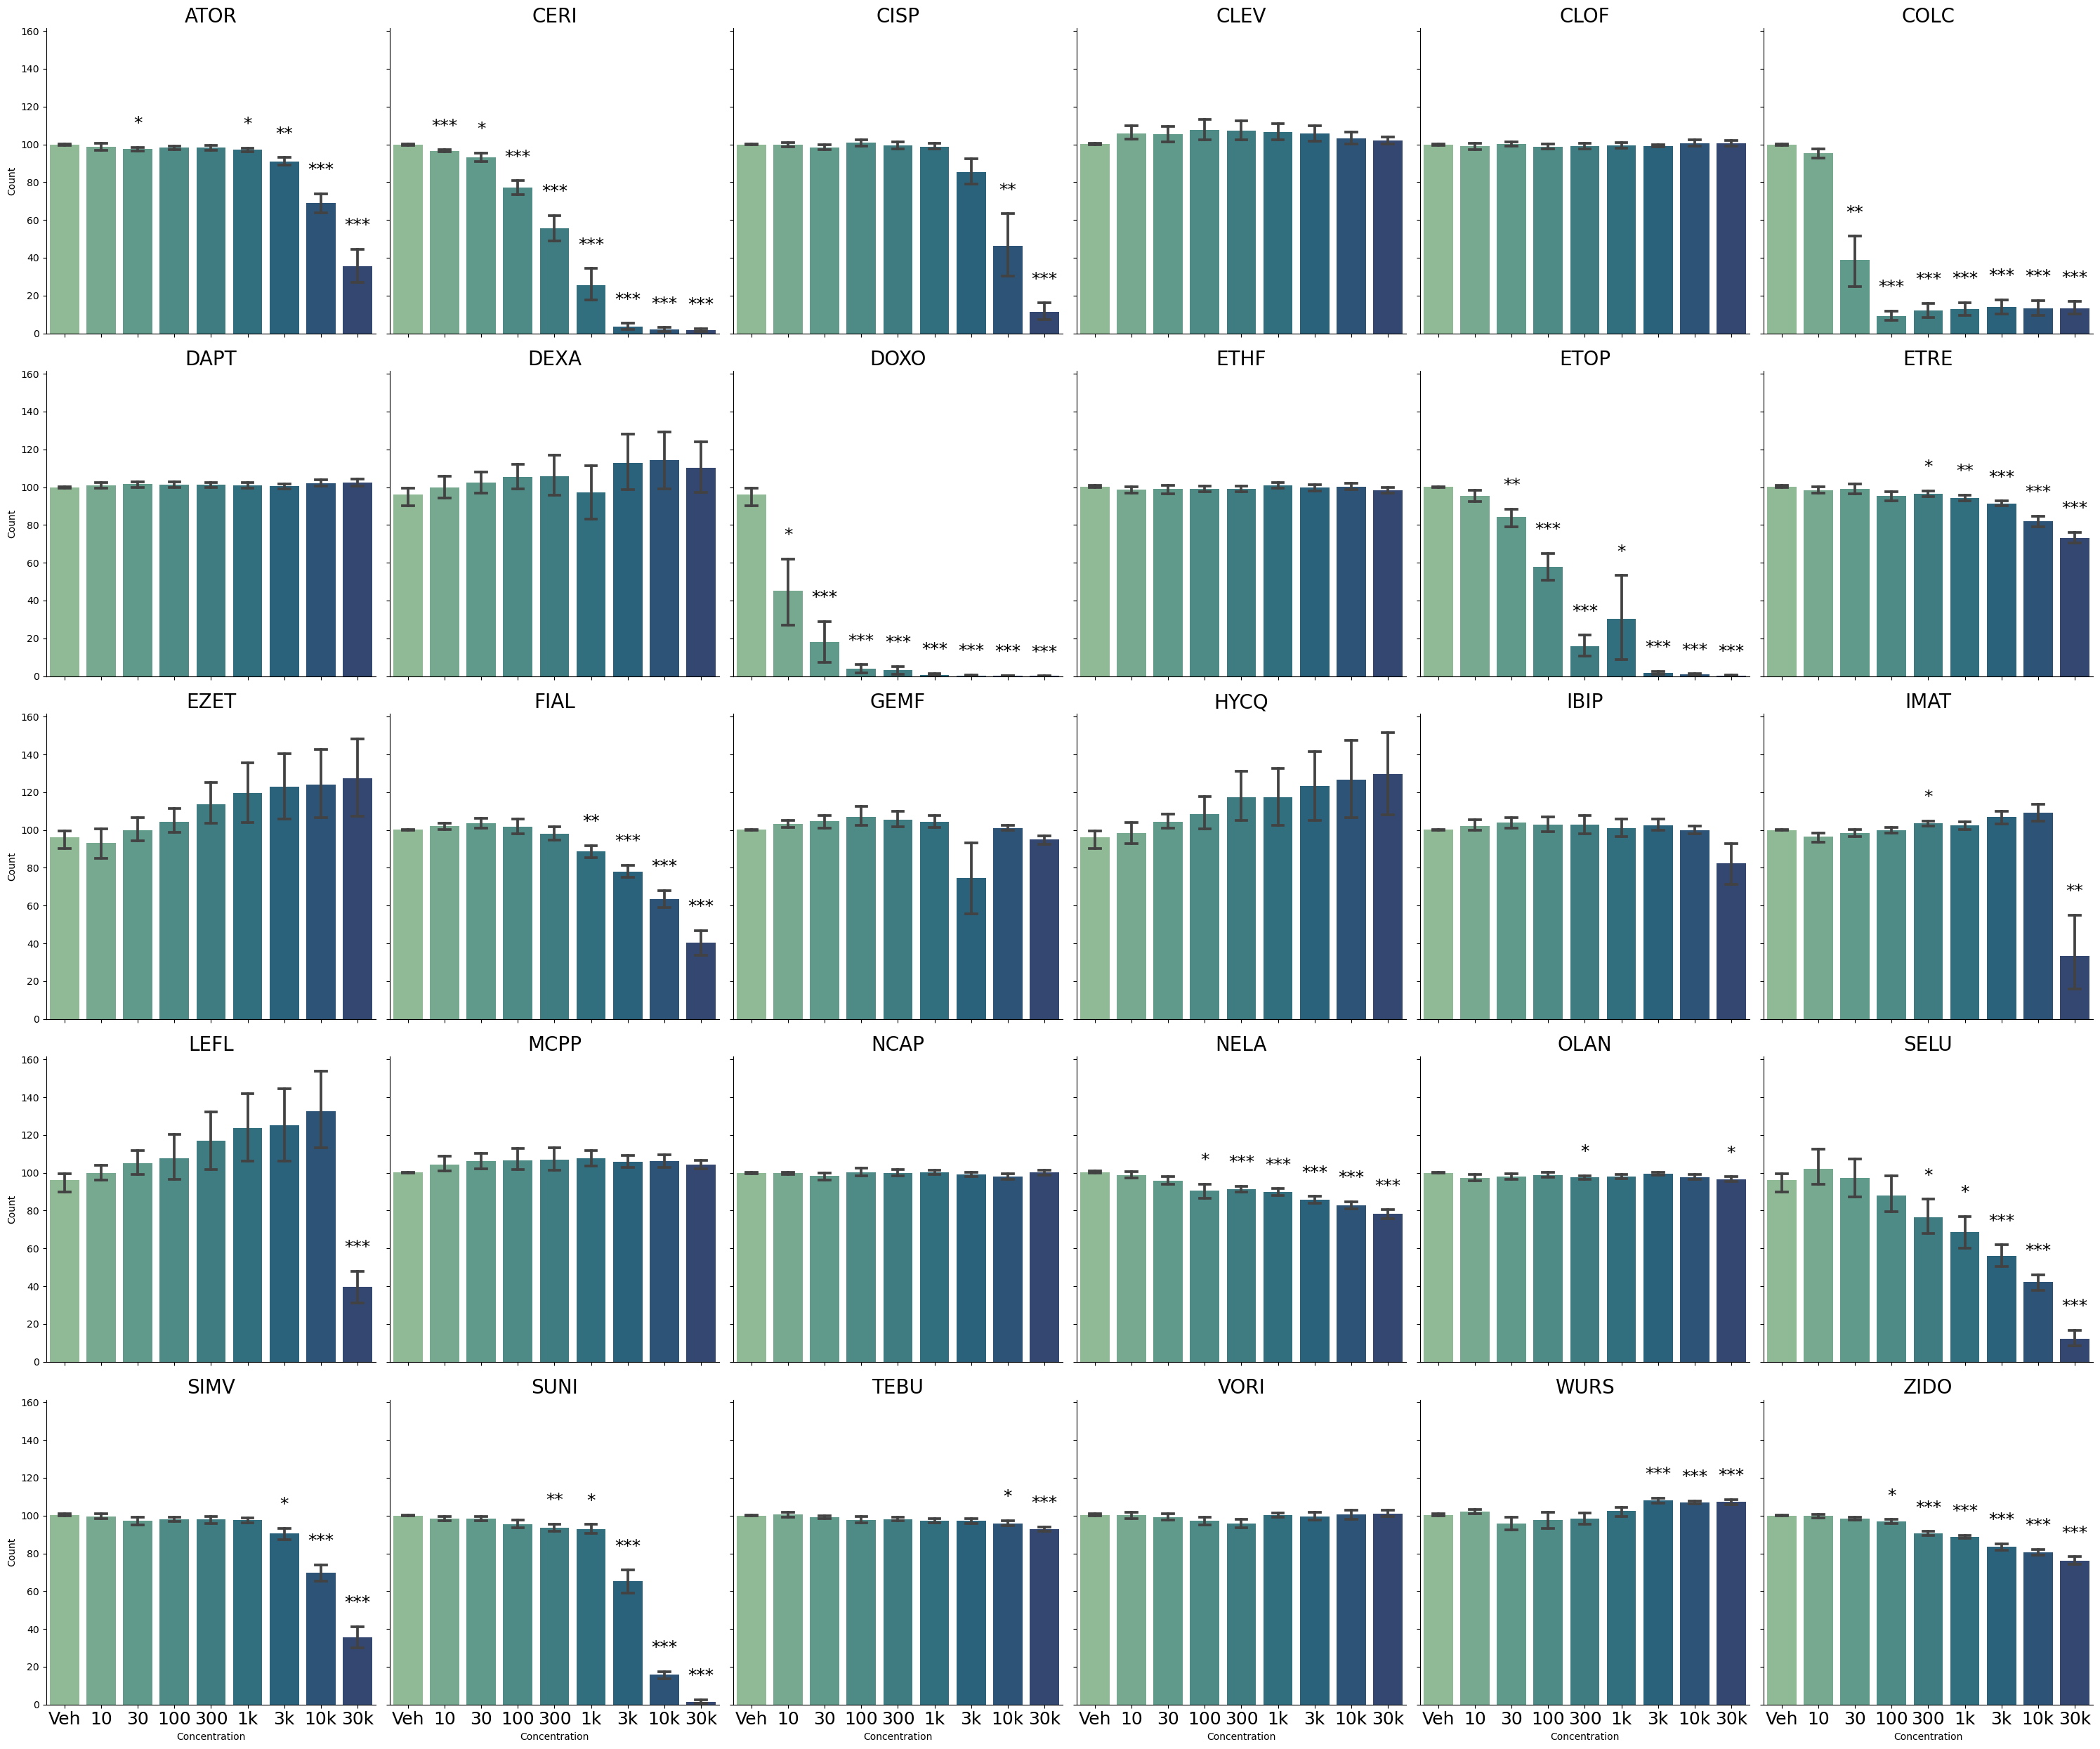

In [115]:
plt.figure(dpi=500)
plotCP = sns.catplot(   data=cp_data_with_dmso_as_drug, 
                        x='Concentration',
                        y='Count',
                        col='Compound', 
                        #hue = 'Replicate', 
                        kind='bar',
                        palette = 'crest',
                        col_wrap=6,
                        capsize=0.3) # add hue='Replicate' to get individual replicates curves
plt.draw()
plotCP.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
plotCP.set_xticklabels(fontdict={'fontsize':18})
#plotCP.tick_params(axis='x', labelrotation = 0)
plotCP.set_xticklabels(['Veh','10','30','100','300','1k','3k','10k','30k'])
plotCP.set_titles(col_template = '{col_name}',size=20)

for ax in plotCP.axes.flat:
    # Get the compound name from the title
    compound = ax.get_title()
    
    # Get the bar heights for this subplot
    bars = ax.patches
    errorbar_lines = [l for l in ax.lines if len(l.get_xdata()) > 1] ##
    # Loop through concentrations and check p-values
    for idx, conc in enumerate([0.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]):
        # Find matching p-value in test_summary
        mask = (test_summary['Compound'] == compound) & (test_summary['Concentration'] == conc)
        if not test_summary[mask].empty:
            p_value = test_summary[mask]['p-value'].values[0]
            if p_value < 0.05:
                bar_height = bars[idx].get_height()
                symbol = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else '*')
                # Find the corresponding error bar
                errorbar_cap = None
                
                for line in errorbar_lines:
                     x_data = line.get_xdata()
                     if len(x_data) > 1 and x_data[0] == bars[idx].get_x() + bars[idx].get_width() / 2:
                        errorbar_cap = line.get_ydata()[1]
                        break

                # Calculate y-position for the symbol
                y_pos = max(bar_height, errorbar_cap if errorbar_cap is not None else 0)
                
                y_pos += 0.05 * ax.get_ylim()[1] # Add some padding above the bar/error bar
                ax.text(idx, y_pos, symbol, ha='center', va='bottom', fontsize=18)
plt.savefig("E:\OneDrive - National University of Ireland, Galway\Figures\Fig2A_v3.tif", dpi=200, pil_kwargs=dict(compression='tiff_lzw'))
plt.tight_layout()

In [116]:
t_tests_ctg = []
for compound in CTGdata_with_dmso_as_drug.Compound.unique():
    compound_df = CTGdata_with_dmso_as_drug.loc[CTGdata_with_dmso_as_drug['Compound']==compound]
    for concentration in compound_df.Concentration.unique():
        if concentration > 0:
            treatment = compound_df.loc[compound_df['Concentration']==concentration]
            controls = compound_df.loc[compound_df['Concentration']==0].groupby(by=['Plate']).mean(numeric_only=True)
            test = ttest_ind(treatment['Cell Viability'],controls['Cell Viability'])
            anova = f_oneway(treatment['Cell Viability'],controls['Cell Viability'])
            t_tests_ctg.append((compound,concentration,test[0],test[1], anova[0],anova[1]))

test_summary_ctg = pd.DataFrame(t_tests_ctg, columns=['Compound','Concentration','t-stat','p-value', 'F-stat','p-value anova'])
test_summary_ctg = test_summary_ctg.sort_values(by='p-value').loc[test_summary_ctg['p-value']<0.05]

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurre

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\roman\AppData\Local\Temp\ipykernel_43272\1073507544.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


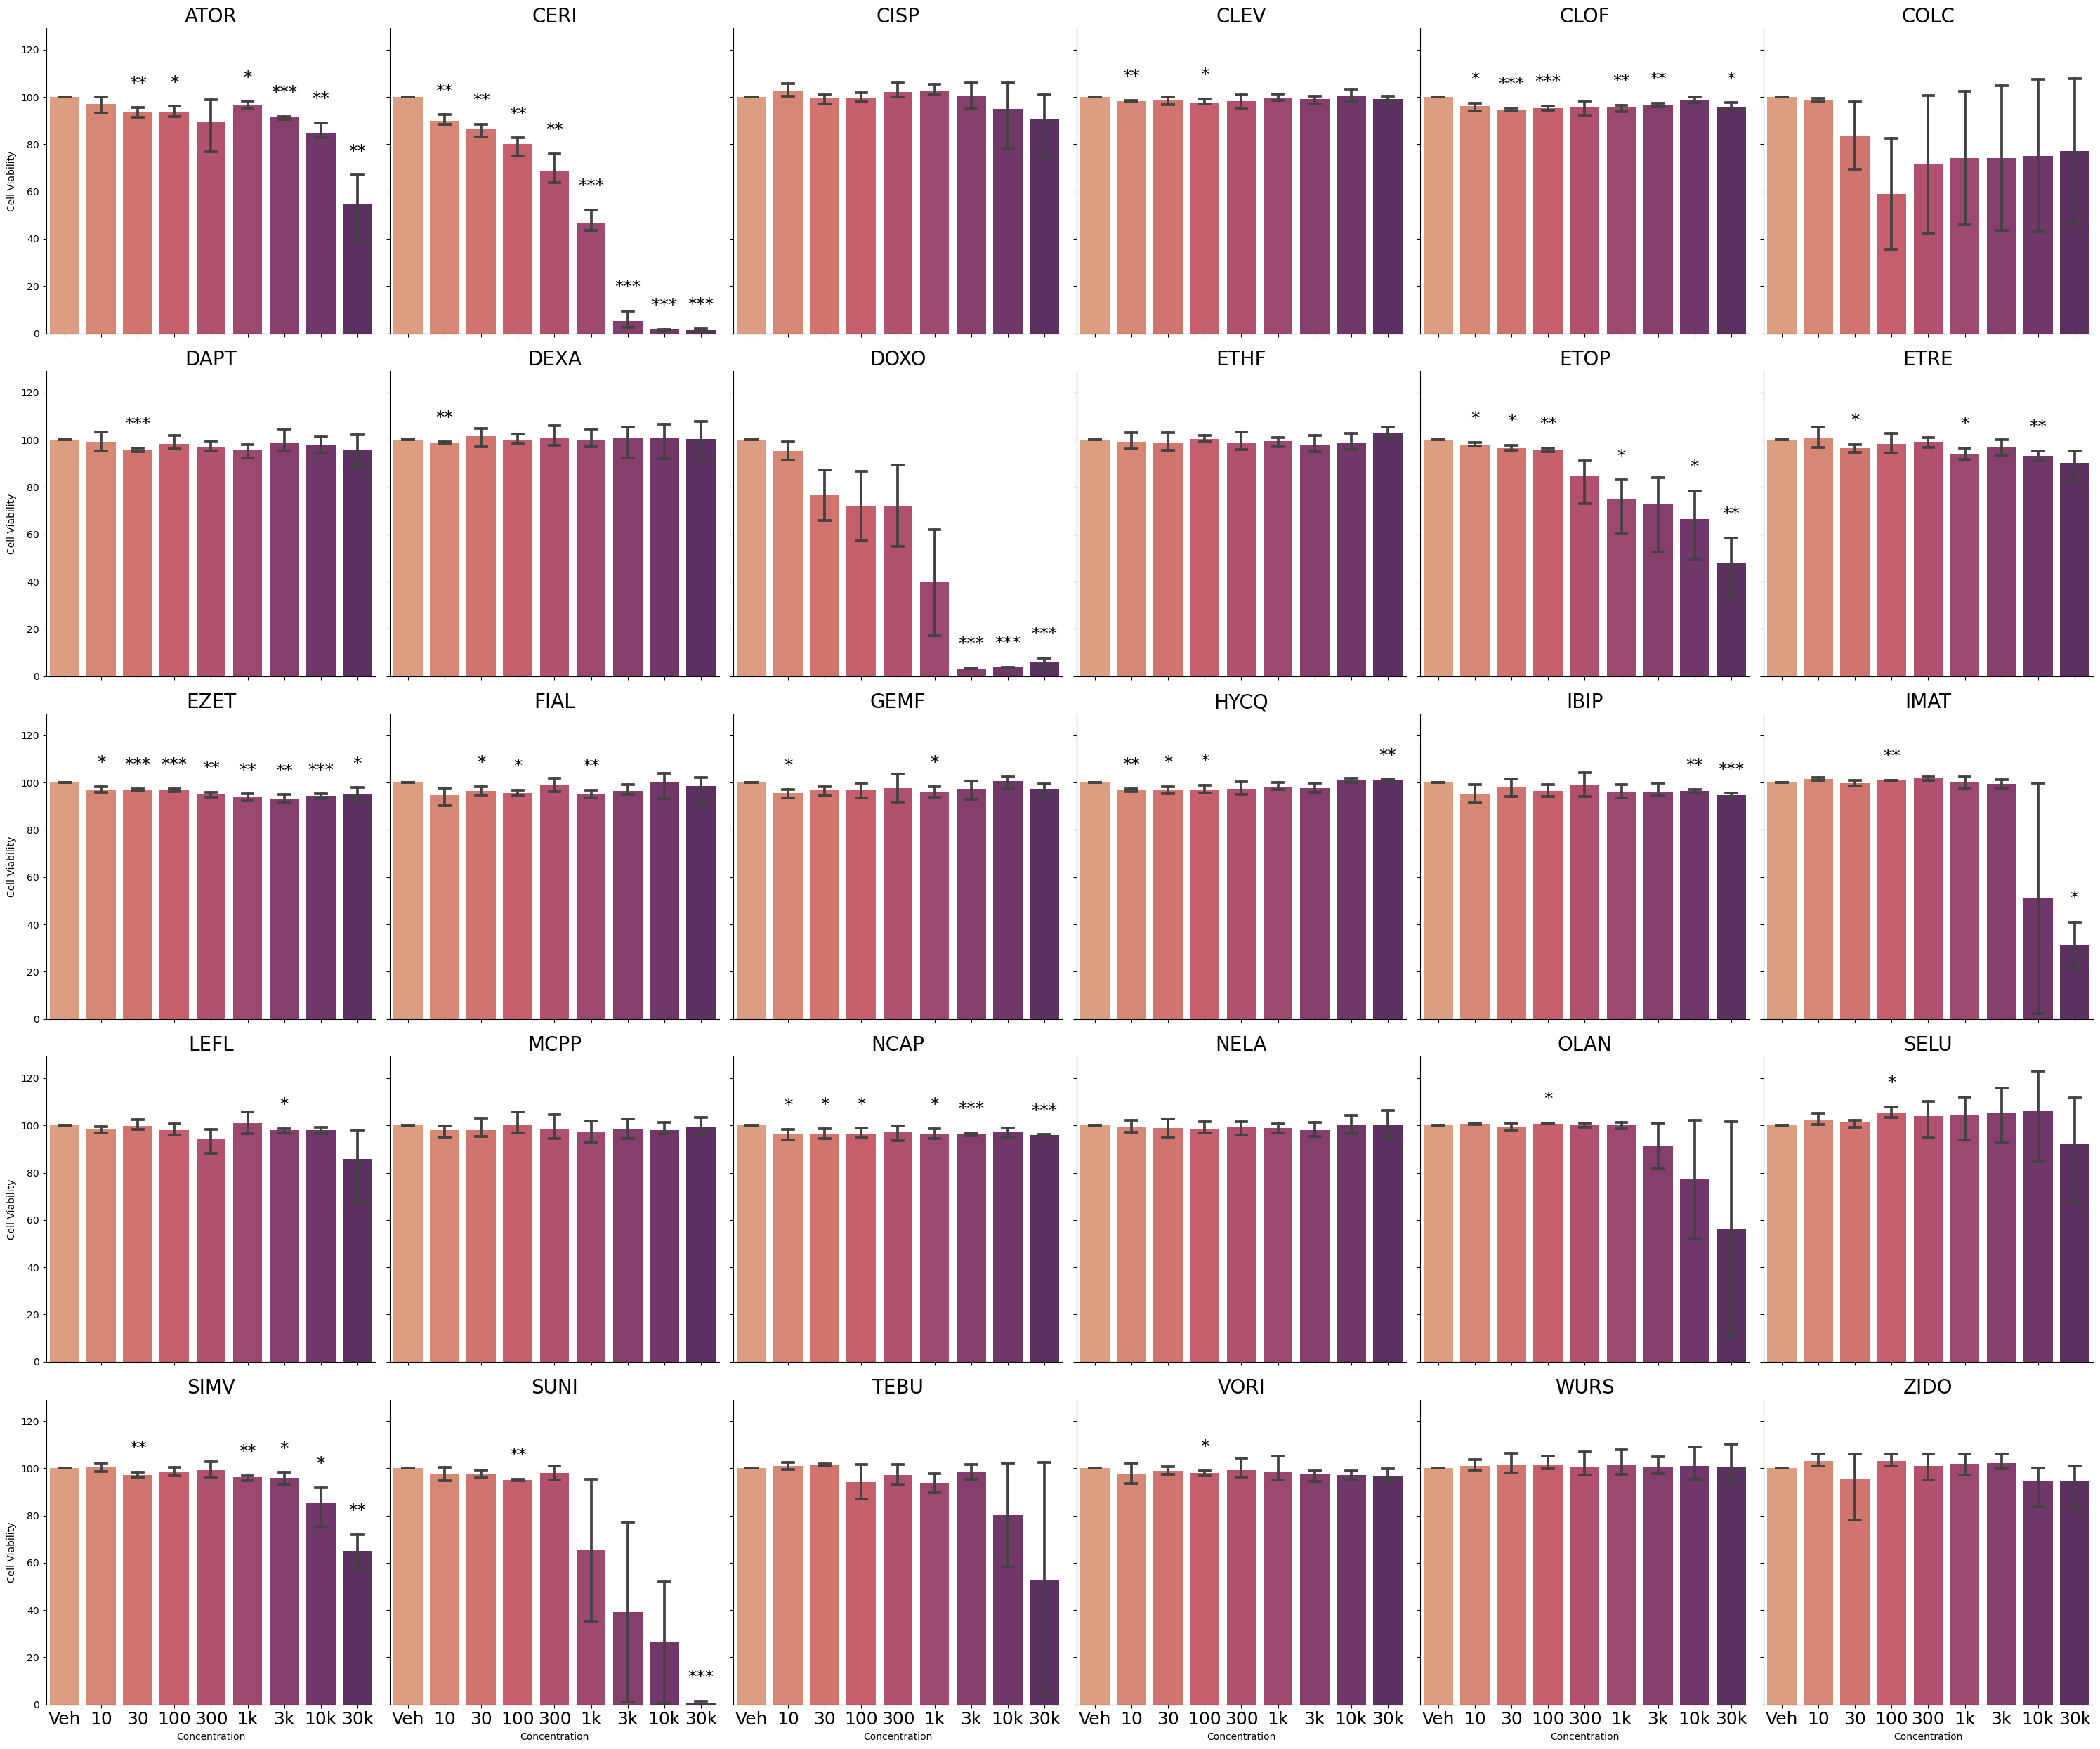

In [117]:
plotCTG = sns.catplot(  data=CTGdata_with_dmso_as_drug, 
                        x='Concentration',
                        y="Cell Viability",
                        col='Compound',
                        kind='bar',
                        #hue='Replicate',
                        palette = 'flare',
                        col_wrap=6,
                        capsize=0.3 )

plotCTG.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
plotCTG.set_xticklabels(fontdict={'fontsize':18})
plotCTG.set_xticklabels(['Veh','10','30','100','300','1k','3k','10k','30k'])
plotCTG.set_titles(col_template = '{col_name}',size=20)

for ax in plotCTG.axes.flat:
    # Get the compound name from the title
    compound = ax.get_title()
    
    # Get the bar heights for this subplot
    bars = ax.patches
    errorbar_lines = [l for l in ax.lines if len(l.get_xdata()) > 1] ##
    # Loop through concentrations and check p-values
    for idx, conc in enumerate([0.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]):
        # Find matching p-value in test_summary
        mask = (test_summary_ctg['Compound'] == compound) & (test_summary_ctg['Concentration'] == conc)
        if not test_summary_ctg[mask].empty:
            p_value = test_summary_ctg[mask]['p-value'].values[0]
            if p_value < 0.05:
                bar_height = bars[idx].get_height()
                symbol = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else '*')
                errorbar_cap = None
                
                for line in errorbar_lines:
                     x_data = line.get_xdata()
                     if len(x_data) > 1 and x_data[0] == bars[idx].get_x() + bars[idx].get_width() / 2:
                        errorbar_cap = line.get_ydata()[1]
                        break

                # Calculate y-position for the symbol
                y_pos = max(bar_height, errorbar_cap if errorbar_cap is not None else 0)
                
                y_pos += 0.05 * ax.get_ylim()[1] # Add some padding above the bar/error bar
                ax.text(idx, y_pos, symbol, ha='center', va='bottom', fontsize=18)
plt.savefig("E:\OneDrive - National University of Ireland, Galway\Figures\Fig2B_v3.tif", dpi=200, pil_kwargs=dict(compression='tiff_lzw'))
plt.tight_layout()


In [118]:
# from statannotations.Annotator import Annotator

# plotCTG = sns.catplot(  data=CTGdata_with_dmso_as_drug, 
#                         x='Concentration',
#                         y="Cell Viability",
#                         col='Compound',
#                         kind='bar',
#                         #hue='Replicate',
#                         col_wrap=6,
#                         capsize=0.3 )
# pairs=[
#         (0.0, 30000.0), 
#         (0.0, 10000.0),
#         (0.0, 3000.0),
#         (0.0, 1000.0),
#         (0.0, 300.0),
#         (0.0, 100.0),
#         (0.0, 30.0),
#         (0.0, 10.0),
#        ]
# ant = Annotator(None, pairs)
# kwargs = {
#     'plot_params': { # this takes what normally goes into sns.barplot etc.
#         'x': 'Concentration',
#         'y': 'Cell Viability',
#         'palette': 'flare',
#     },
#     'annotation_func': 'apply_test', # has three options
#     'configuration': {'test': 't-test_ind', 
#                       'hide_non_significant': True, 
#                       'verbose': False,
#                       'loc': 'inside',
#                       'line_offset': 0,
#                     'line_height': 0,
#                     'line_width': 0,
#                       }, # this takes what normally goes into ant.configure
#     'plot': 'barplot'
# }

# plotCTG.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
# #plotCTG.set_xticklabels(labels= plotCTG.facet_axis rotation=30)
# plotCTG.set_titles(row_template = '{row_name}', col_template = '{col_name}',size=18)
# # change the x axis title to Concentration (nM)
# plotCTG.set_xlabels('Concentration (nM)')
# #plotCTG.tick_params(axis='x', labelrotation = 0)
# plotCTG.set_xticklabels(['Veh','10','30','100','300','1k','3k','10k','30k'])
# plotCTG.set_titles(col_template = '{col_name}',size=20)